In [ ]:
#This notebook applies a large-vocabulary bigram language model (50k words) implemented in Kaldi to the RNN outputs.
#It also measures character/word error rates after the language model has been applied. 
#本笔记本将用Kaldi实现的大词汇量bigram语言模型（50k单词）应用于RNN输出。
#它还测量应用语言模型后的字符/单词错误率。
#Kaldi是当前最流行的开源语音识别工具(Toolkit)

In [2]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt

#point this towards the top level dataset directory
#将其指向顶级数据集目录
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#point this towards the code directory
#把这个指向代码目录
repoDir = os.getcwd() + '/'

#defines which train/test partition to use
#定义要使用的训练/测试分区
cvPart = 'HeldOutTrials'

#defines which datasets to process
#定义要处理的数据集
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

In [3]:
#First we have to convert the RNN outputs to a format that Kaldi can read. Here we make a Kaldi-readable matrix
#for each sentence that contains the RNN outputs. 
#首先，我们必须将RNN输出转换为Kaldi可以读取的格式。这里我们制作一个Kaldi可读矩阵
#对于包含RNN输出的每个句子。
from characterDefinitions import getHandwritingCharacterDefinitions
from rnnEval import rnnOutputToKaldiMatrices

charDef = getHandwritingCharacterDefinitions()
allErrCounts = []
outDir = rootDir+'RNNTrainingSteps/Step5_RNNInference/' + cvPart

for x in range(len(dataDirs)):
    print(dataDirs[x])
    
    outputs = scipy.io.loadmat(outDir + '/' + dataDirs[x] + '_inferenceOutputs.mat')
    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat')
    
    #define where to save the Kaldi matrices
    #定义保存Kaldi矩阵的位置
    kaldiDir = rootDir+'RNNTrainingSteps/Step6_ApplyBigramLM/' + cvPart + '/KaldiMatrices/' + dataDirs[x] + '/'
    if not os.path.isdir(kaldiDir):
        os.mkdir(kaldiDir)

    #This function converts the RNN output to kaldi matrices so the language model can process it.
    #此函数用于将RNN输出转换为kaldi矩阵，以便语言模型可以对其进行处理。
    #Note that as part of this process we use the RNN's character start signal output to create a fake 'CTC blank' signal
    #注意，作为这个过程的一部分，我们使用RNN的字符开始信号输出来创建一个伪“CTC空白”信号
    #for the language model (the language model was originally designed to be used with a CTC loss).
    #对于语言模型（语言模型最初设计为与CTC一起使用）。
    #CTC 的全称是Connectionist Temporal Classification.这个方法主要是解决神经网络label 和output 不对齐的问题（Alignment problem）
    cProb = rnnOutputToKaldiMatrices(outputs['outputs'], 
                             sentenceDat['numTimeBinsPerSentence']/2+50, 
                             charDef, 
                             kaldiDir)

t5.2019.05.08
t5.2019.11.25
t5.2019.12.09
t5.2019.12.11
t5.2019.12.18
t5.2019.12.20
t5.2020.01.06
t5.2020.01.08
t5.2020.01.13
t5.2020.01.15


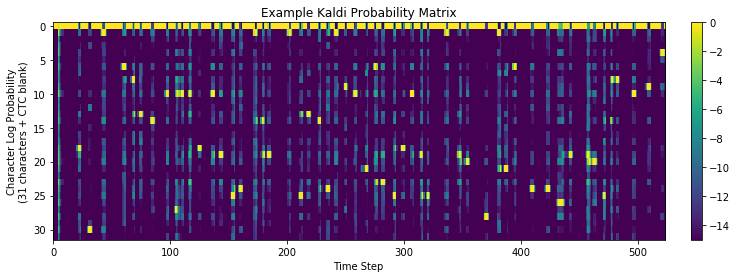

In [4]:
#Visualize what a Kaldi matrix looks like. Note that the first row is the CTC-blank signal, which goes low only briefly whenever
#there is a new character.
##想象一下Kaldi矩阵是什么样子。请注意，第一行是CTC空白信号，只有在出现新字符时才会短暂变低。
plt.figure(figsize=(12,4))
plt.imshow(cProb[122].T, aspect='auto', clim=[0,-15])
plt.xlabel('Time Step')
plt.ylabel('Character Log Probability\n(31 characters + CTC blank)')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Example Kaldi Probability Matrix')
plt.show()

In [5]:
#Now call kaldi to apply the language model to the probability matrices created above.
#Note that you will need kaldi (https://github.com/kaldi-asr/kaldi) 
#AND you will need custom kaldi decoders from https://github.com/jpuigcerver/kaldi-decoders.
#现在调用kaldi将语言模型应用于上面创建的概率矩阵。
#请注意，您将需要kaldi(https://github.com/kaldi-asr/kaldi)
#你需要定制kaldi解码器https://github.com/jpuigcerver/kaldi-decoders.
from parallelBash import parallelBash
import time
import multiprocessing

#Add kaldi and kaldi-decoders binaries to the path. This assumes that kaldi is located in the home directory.
#将kaldi和kaldi解码器二进制文件添加到路径。这假设kaldi位于主目录中。
homeDir = os.path.expanduser('~/')
os.environ['PATH'] += ':'+homeDir+'kaldi-decoders/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/lm'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/lmbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/fstbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/featbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/gmmbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/tools/openfst-1.6.7/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/latbin'

#make sure we have permission to execute all the scripts we'll be calling below
#确保我们有权限执行下面调用的所有脚本
os.system('chmod +x ' + repoDir+'kaldiLMScripts/bigramLmDecode.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/parseOptions.inc.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/remove_transcript_dummy_boundaries.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/int2sym.pl')

#for each dataset, we launch multiple instances of the kaldi decoder program in parallel, each operating on a single sentence
#对于每个数据集，我们并行启动多个kaldi解码器程序实例，每个实例操作一个句子
for dataDir in dataDirs:
    print(dataDir)

    #where the language model files are stored
    #存储语言模型文件的位置
    langModelDir = rootDir+'BigramLM'
    
    #where the kaldi probability matrices are saved (these are inputs for this step)
    #保存kaldi概率矩阵的地方（这些是本步骤的输入）
    matsDir = rootDir+'RNNTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiMatrices/'+dataDir
    
    #where we should save the language model outputs (which are lists of candidate sentences, along with their scores)
    #我们应该在哪里保存语言模型输出（即候选句子列表及其分数）
    outDir = rootDir+'RNNTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiOutput/'+dataDir
    if not os.path.isdir(outDir):
        os.mkdir(outDir)
        
    #clear previous LM outputs
    #清除以前的LM输出
    os.system('rm ' + outDir + '/*')

    #This next bit of code generates some temporary .sh files that help launch multiple decoding programs at once.
    #we then launch the '_master.sh' file to kick everything off, and wait until the outputs are all there before continuing
   # to the next dataset.
    #下一段代码会生成一些temporary .sh文件帮助一次启动多个解码程序
   # 然后我们启动_master.sh文件启动所有操作，并等待输出全部完成后再继续转到下一个数据集。
    scriptFile = repoDir + 'kaldiLMScripts/bigramLmDecode.sh'
    
    if not os.path.isdir(rootDir + 'RNNTrainingSteps/bashScratch'):
        os.mkdir(rootDir + 'RNNTrainingSteps/bashScratch')
    bashFilePrefix = rootDir + 'RNNTrainingSteps/bashScratch/lmDecode'
    
    fileList = os.listdir(matsDir)
    txtFiles = []
    for f in fileList:
        if f.endswith('.txt'):
            txtFiles.append(f)
            
    nFiles = len(txtFiles)    
    nParallelProcesses = int(multiprocessing.cpu_count()/2)

    sentenceIdx = np.arange(0,nFiles).astype(np.int32)
    
    argList = []
    for x in range(len(sentenceIdx)):
        newArgs = {}
        newArgs['acoustic_scale'] = 1.0 #1.0, 1.79
        newArgs['beam'] = 65
        newArgs['max_active'] = 5000 #500000 #5000000
        newArgs['1_mainArg'] = langModelDir
        newArgs['2_mainArg'] = matsDir + '/kaldiMat_'+str(sentenceIdx[x])+'.txt'
        newArgs['3_mainArg'] = outDir + '/' + str(sentenceIdx[x]) + '_'

        argList.append(newArgs)

    #this utility function generates temporary .sh files for running parallel decoding
    #此实用程序函数生成temporary .sh files 用于运行并行解码。
    parallelBash(argList, scriptFile, bashFilePrefix, nParallelProcesses)
        
    #make sure we have permissions to execute everything
    #确保我们有执行一切的权限
    os.system('chmod +x ' + bashFilePrefix+'_master.sh')
    for x in range(nParallelProcesses):
        os.system('chmod +x ' + bashFilePrefix+'_'+str(x)+'.sh')
            
    #launching the master file starts everything
    #启动主文件会启动一切
    os.system(bashFilePrefix+'_master.sh')

    #now we just sit and wait until we have all the outputs
    #现在我们只是坐着等待，直到我们有了所有的输出
    numFilesInDir = 0
    while numFilesInDir < nFiles*9:
        numFilesInDir = int(len(os.listdir(outDir)))
        time.sleep(1)

t5.2019.05.08
t5.2019.11.25
t5.2019.12.09
t5.2019.12.11
t5.2019.12.18
t5.2019.12.20
t5.2020.01.06
t5.2020.01.08
t5.2020.01.13
t5.2020.01.15


In [ ]:
#Now that we have all the language model outputs, load them up and compute character/word error rates
#现在我们有了所有的语言模型输出，加载它们并计算字符/单词错误率
from kaldiReadWrite import readKaldiLatticeFile, readKaldiAliFile
import numpy as np
import scipy.io
from rnnEval import wer
import warnings

#this stops scipy.io.savemat from throwing a warning about empty entries
#这阻止了scipy.io.savemat避免抛出关于空条目的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

#keep track of the error counts for all validation sentences in 'valErrCounts' so we can summarize in the next cell
#跟踪“ValerCounts”中所有验证语句的错误计数，以便我们在下一个单元格中进行总结
valErrCounts = []

for dataDir in dataDirs:
    #process ALL sentences from this dataset (both train & test)
    #处理该数据集中的所有句子（训练和测试）
    print(' --' + dataDir + '-- ')

    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/sentences.mat')
    cvPartFile = scipy.io.loadmat(rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat')
    valIdx = cvPartFile[dataDir+'_test']
    
    allErrCounts = []
    decSentences = []
    
    kaldiDir = rootDir+'RNNTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiOutput/'+dataDir 
    nFiles = int(len(os.listdir(kaldiDir))/9)   
    
    for fileIdx in range(nFiles):
        nbestFile = kaldiDir+'/'+str(fileIdx)+'_transcript.txt'
        acFile = kaldiDir+'/'+str(fileIdx)+'_best_acscore.ark'
        lmFile = kaldiDir+'/'+str(fileIdx)+'_best_lmscore.ark'

        nums, content = readKaldiLatticeFile(nbestFile, 'string')
        _, acScore = readKaldiLatticeFile(acFile, 'numeric')
        _, lmScore = readKaldiLatticeFile(lmFile, 'numeric')

        #here we select the best-scoring sentence according to the formula 'acScore + 2.0*lmScore'
        #这里我们根据公式“acScore+2.0*lmScore”选择最佳评分句子
        bestIdx = np.argmin(acScore + 2.0*lmScore)
        decSent = content[bestIdx]
        decSentences.append(decSent)
        
        trueText = sentenceDat['sentencePrompt'][fileIdx,0][0]
        trueText = trueText.replace('>',' ')
        trueText = trueText.replace('~','.')
        trueText = trueText.replace('#','')
        
        #compute character/word error counts
        
        charErrs = wer(trueText, decSent)
        wordErrs = wer(trueText.split(), decSent.split())
        allErrCounts.append(np.array([charErrs, len(trueText), wordErrs, len(trueText.split())]))

        #print the language model outputs for all sentences in the held-out set
        #打印保留集合中所有句子的语言模型输出
        if fileIdx in valIdx:
            print('#' + str(fileIdx))
            print('True:    ' + trueText)
            print('Decoded: ' + decSent)
            print('')
            
            valErrCounts.append(np.array([charErrs, len(trueText), wordErrs, len(trueText.split())]))

    #save error rates & decoded sentences for this dataset
    #保存此数据集的错误率和解码句子
    concatCounts = np.stack(allErrCounts, axis=0)

    saveDict = {}
    saveDict['decSentences'] = decSentences
    saveDict['trueSentences'] = sentenceDat['sentencePrompt']
    saveDict['charCounts'] = concatCounts[:,1]
    saveDict['charErrors'] = concatCounts[:,0]
    saveDict['wordCounts'] = concatCounts[:,3]
    saveDict['wordErrors'] = concatCounts[:,2]

    scipy.io.savemat(rootDir + 'RNNTrainingSteps/Step6_ApplyBigramLM/' + cvPart + '/' + dataDir + '_errCounts.mat', saveDict)

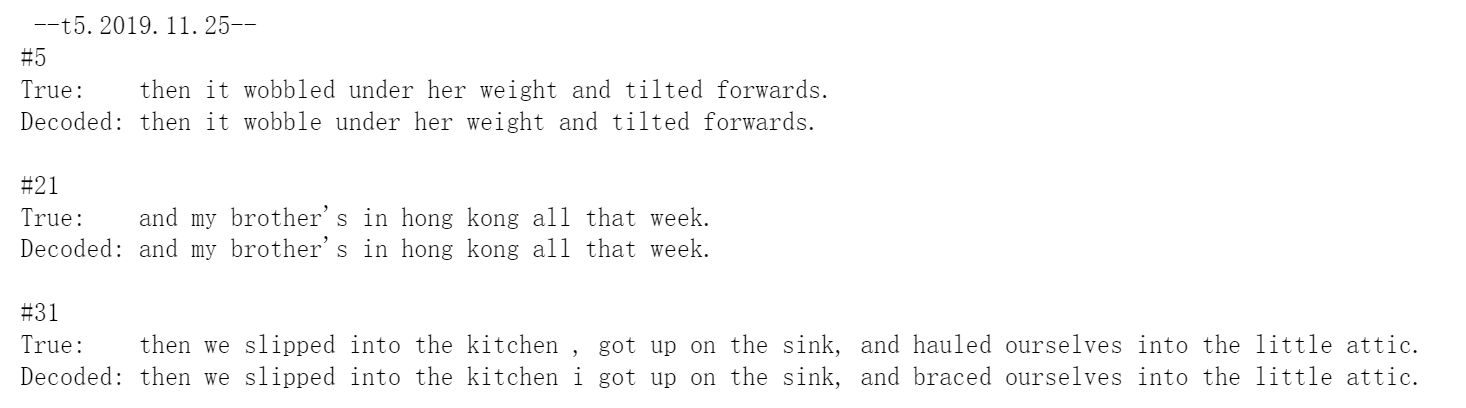

In [8]:
#Summarize character error rate and word error rate across all held-out trials from all datasets
#总结从所有数据集中进行的所有试验的字符错误率和单词错误率
concatErrCounts = np.squeeze(np.stack(valErrCounts, axis=0))
cer = 100*(np.sum(concatErrCounts[:,0]) / np.sum(concatErrCounts[:,1]))
wer = 100*(np.sum(concatErrCounts[:,2]) / np.sum(concatErrCounts[:,3]))

print('Character error rate: %1.2f%%' % float(cer))
print('Word error rate: %1.2f%%' % float(wer))

Character error rate: 0.80%
Word error rate: 3.64%
